In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7

from tensorflow import optimizers

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model



from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:


train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,           # Apply random shear transformations
    zoom_range=0.2,            # Randomly zoom into images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in missing pixels with nearest pixel values
)

# Define ImageDataGenerator for validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Set batch size
batch_size = 32

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive (9) - Copy - Copy/Data/train',                 # Directory containing training images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size, # Batch size
    seed=42,class_mode='categorical'   # Specify categorical labels
)

# Flow validation images in batches using validation_datagen
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive (9) - Copy - Copy/Data/test',            # Directory containing validation images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size,     # Batch size
    shuffle=False,seed=42,class_mode='categorical'   # Specify categorical labels
)

Found 1437 images belonging to 3 classes.
Found 404 images belonging to 3 classes.


In [ ]:
inception = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
#here [3] denotes for RGB images(3 channels)

#don't train existing weights
for layer in inception.layers:
 layer.trainable = False

x = Flatten()(inception.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 111, 111, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_18

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# Define callbacks
checkpoint = ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min', min_lr=1e-6)

callbacks = [checkpoint, lr_scheduler]

# Define learning rate scheduler
def lr_schedule(epoch):
    """
    Learning rate scheduler.
    """
    initial_lr = 0.01
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * 0.1

# Training configuration
epochs = 15
initial_learning_rate = 0.01
steps_per_epoch = len(train_generator)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Start training
start_time = datetime.now()

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks)

# Calculate training duration
training_duration = datetime.now() - start_time
print("Training duration:", training_duration)


Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 14.0853 - accuracy: 0.5859 
Epoch 1: val_loss improved from inf to 0.95158, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 1044s 23s/step - loss: 14.0853 - accuracy: 0.5859 - val_loss: 0.9516 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 2.2716 - accuracy: 0.7439
Epoch 2: val_loss improved from 0.95158 to 0.35767, saving model to model_checkpoint.h5
45/45 [==============================] - 57s 1s/step - loss: 2.2716 - accuracy: 0.7439 - val_loss: 0.3577 - val_accuracy: 0.8812 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.7495
Epoch 3: val_loss improved from 0.35767 to 0.30964, saving model to model_checkpoint.h5
45/45 [==============================] - 60s 1s/step - loss: 0.7388 - accuracy: 0.7495 - val_loss: 0.3096 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.7363
Epoch 4: val_loss did not improve from 0.30964
45/45 [==============================] - 53s 1s/step - loss: 0.70

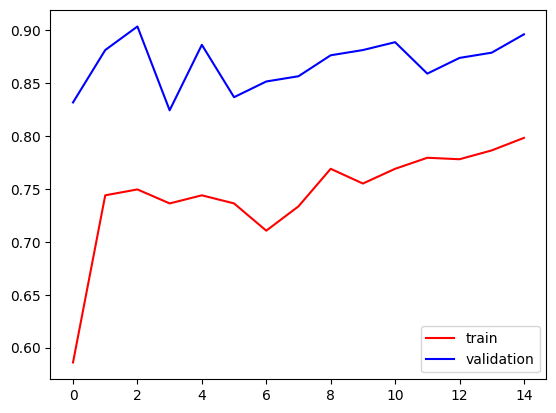

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

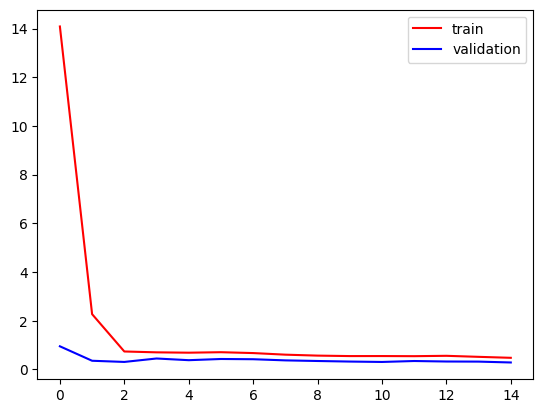

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 9s 579ms/step - loss: 0.2872 - accuracy: 0.8960
Test Loss: 0.28719884157180786
Test Accuracy: 0.896039605140686


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
# Assuming you have already trained your model and loaded test data

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_generator)

# Predict classes for training set
train_predictions = model.predict(train_generator)
train_predicted_classes = np.argmax(train_predictions, axis=1)

# Get true labels for training set
train_true_classes = train_generator.classes

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Generate classification report for training set
train_report = classification_report(train_true_classes, train_predicted_classes, target_names=class_labels)

print("Training Classification Report:")
print(train_report)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

# Predict classes for validation set
val_predictions = model.predict(validation_generator)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Get true labels for validation set
val_true_classes = validation_generator.classes

# Generate classification report for validation set
val_report = classification_report(val_true_classes, val_predicted_classes, target_names=class_labels)

print("Validation Classification Report:")
print(val_report)


45/45 [==============================] - 48s 1s/step
Training Classification Report:
              precision    recall  f1-score   support

     COVID19       0.31      0.32      0.32       460
      NORMAL       0.35      0.40      0.37       504
   PNEUMONIA       0.32      0.27      0.29       473

    accuracy                           0.33      1437
   macro avg       0.33      0.33      0.33      1437
weighted avg       0.33      0.33      0.33      1437

13/13 [==============================] - 9s 606ms/step
Validation Classification Report:
              precision    recall  f1-score   support

     COVID19       0.97      0.94      0.96       116
      NORMAL       0.82      0.99      0.90       160
   PNEUMONIA       0.96      0.74      0.84       128

    accuracy                           0.90       404
   macro avg       0.92      0.89      0.90       404
weighted avg       0.91      0.90      0.89       404

